<a href="https://colab.research.google.com/github/kssv23/Machine-Learning/blob/main/Assign_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

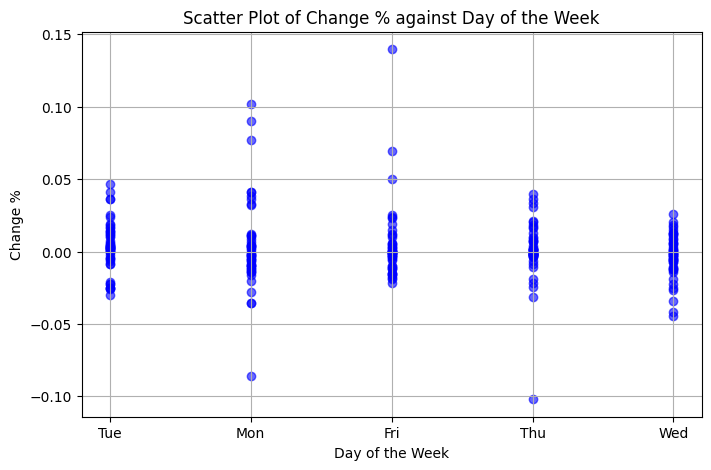

<ipython-input-3-e77ddd9c637c>:55: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  thyroid.replace("?", np.nan, inplace=True)
<ipython-input-3-e77ddd9c637c>:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  thyroid[col].fillna(thyroid[col].median(), inplace=True)
<ipython-input-3-e77ddd9c637c>:69: Fut

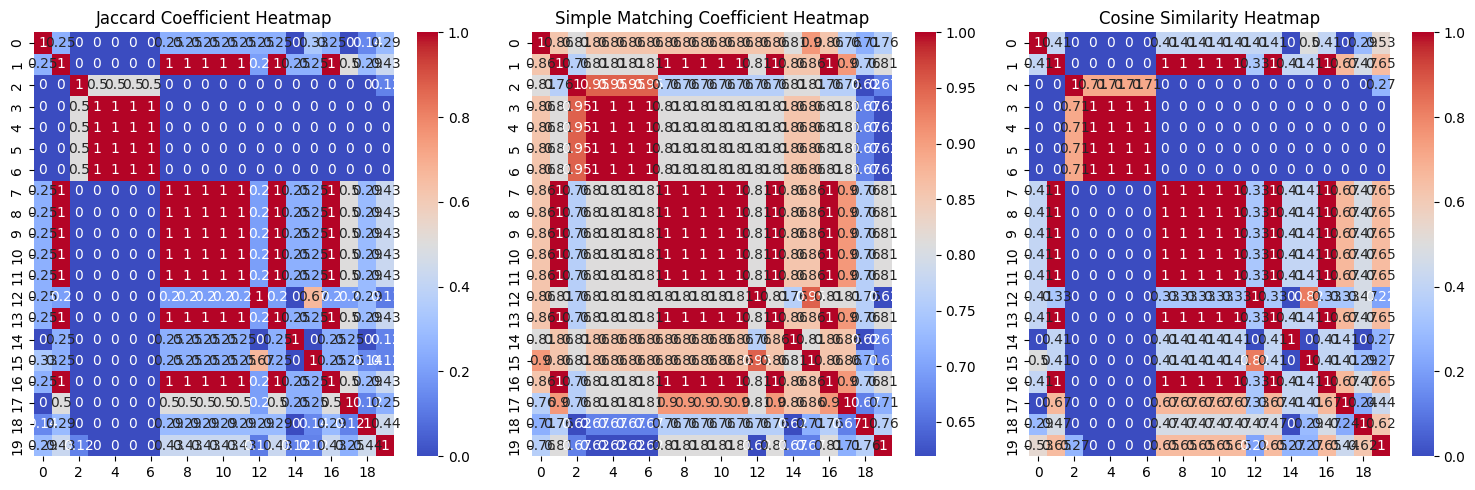

                                           Metric         Value
0                                      Mean Price   1560.663454
1                                  Variance Price  58732.365353
2                            Mean Wednesday Price   1550.706000
3                                Mean April Price   1698.952632
4                             Probability of Loss      0.497992
5  Conditional Probability of Profit on Wednesday      0.843387
6                             Jaccard Coefficient      0.250000
7                     Simple Matching Coefficient      0.857143
8                               Cosine Similarity      0.997701


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from numpy.linalg import pinv, norm

file_path = "/content/Lab Session Data.xlsx"
xls = pd.ExcelFile(file_path)
sheets = {name.lower().strip(): name for name in xls.sheet_names}

purchase_sheet = sheets.get("purchase data", None)
if not purchase_sheet:
    raise ValueError("Sheet 'Purchase Data' not found in the Excel file.")
purchase_data = pd.read_excel(file_path, sheet_name=purchase_sheet)

A = purchase_data.iloc[:, 1:4].to_numpy()
C = purchase_data.iloc[:, [4]].to_numpy()
dimensionality = A.shape[1]
num_vectors = A.shape[0]
rank_A = np.linalg.matrix_rank(A)
A_pseudo_inv = pinv(A)
X = np.dot(A_pseudo_inv, C)
purchase_data["Customer_Class"] = np.where(C.flatten() > 200, "RICH", "POOR")

stock_sheet = sheets.get("irctc stock price", None)
if not stock_sheet:
    raise ValueError("Sheet 'IRCTC Stock Price' not found in the Excel file.")
IRCTC = pd.read_excel(file_path, sheet_name=stock_sheet)

mean_price = statistics.mean(IRCTC["Price"])
variance_price = statistics.variance(IRCTC["Price"])
wednesday_prices = IRCTC[IRCTC["Day"] == "Wed"]["Price"]
mean_wednesday = statistics.mean(wednesday_prices)
april_prices = IRCTC[IRCTC["Month"] == "Apr"]["Price"]
mean_april = statistics.mean(april_prices)
prob_loss = (IRCTC["Chg%"] < 0).mean()
wed_total = sum(IRCTC["Day"] == "Wed")
wed_profit = sum((IRCTC["Chg%"] > 0) & (IRCTC["Day"] == "Wed")) / wed_total
conditional_prob_profit_wed = wed_profit / prob_loss

plt.figure(figsize=(8, 5))
plt.scatter(IRCTC["Day"], IRCTC["Chg%"], color="blue", alpha=0.6)
plt.xlabel("Day of the Week")
plt.ylabel("Change %")
plt.title("Scatter Plot of Change % against Day of the Week")
plt.grid()
plt.show()

thyroid_sheet = sheets.get("thyroid0387_uci", None)
if not thyroid_sheet:
    raise ValueError("Sheet 'thyroid0387_UCI' not found in the Excel file.")
thyroid = pd.read_excel(file_path, sheet_name=thyroid_sheet)
thyroid.replace("?", np.nan, inplace=True)
for col in thyroid.select_dtypes(include=[np.number]).columns:
    thyroid[col].fillna(thyroid[col].median(), inplace=True)

scaler = MinMaxScaler()
thyroid[thyroid.select_dtypes(include=[np.number]).columns] = scaler.fit_transform(thyroid[thyroid.select_dtypes(include=[np.number]).columns])

boolean_columns = [
    "on thyroxine", "query on thyroxine", "on antithyroid medication", "sick",
    "pregnant", "thyroid surgery", "I131 treatment", "query hypothyroid",
    "query hyperthyroid", "lithium", "goitre", "tumor", "hypopituitary",
    "psych", "TSH measured", "T3 measured", "TT4 measured", "T4U measured",
    "FTI measured", "TBG measured"
]
thyroid[boolean_columns] = thyroid[boolean_columns].replace({'t': 1, 'f': 0})
thyroid["sex"] = thyroid["sex"].replace({'F': 0, 'M': 1}).fillna(0)
label_encoder = LabelEncoder()
thyroid["referral source"] = label_encoder.fit_transform(thyroid["referral source"])
thyroid["Condition"] = label_encoder.fit_transform(thyroid["Condition"])

binary_columns = boolean_columns + ["sex"]
vector_1 = thyroid[binary_columns].iloc[0].astype(int)
vector_2 = thyroid[binary_columns].iloc[1].astype(int)
f11 = sum((vector_1 == 1) & (vector_2 == 1))
f10 = sum((vector_1 == 1) & (vector_2 == 0))
f01 = sum((vector_1 == 0) & (vector_2 == 1))
f00 = sum((vector_1 == 0) & (vector_2 == 0))
jc = f11 / (f11 + f10 + f01) if (f11 + f10 + f01) > 0 else 0
smc = (f11 + f00) / (f11 + f10 + f01 + f00)
vector_1_full = thyroid.iloc[0].astype(float)
vector_2_full = thyroid.iloc[1].astype(float)
cosine_similarity = np.dot(vector_1_full, vector_2_full) / (norm(vector_1_full) * norm(vector_2_full))

subset = thyroid[binary_columns].iloc[:20].astype(int)
n = len(subset)
jc_matrix, smc_matrix, cosine_matrix = np.zeros((n, n)), np.zeros((n, n)), np.zeros((n, n))
for i in range(n):
    for j in range(n):
        v1, v2 = subset.iloc[i], subset.iloc[j]
        f11 = sum((v1 == 1) & (v2 == 1))
        f10 = sum((v1 == 1) & (v2 == 0))
        f01 = sum((v1 == 0) & (v2 == 1))
        f00 = sum((v1 == 0) & (v2 == 0))
        jc_matrix[i, j] = f11 / (f11 + f10 + f01) if (f11 + f10 + f01) > 0 else 0
        smc_matrix[i, j] = (f11 + f00) / (f11 + f10 + f01 + f00)
        cosine_matrix[i, j] = np.dot(v1, v2) / (norm(v1) * norm(v2))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(jc_matrix, annot=True, cmap='coolwarm')
plt.title("Jaccard Coefficient Heatmap")

plt.subplot(1, 3, 2)
sns.heatmap(smc_matrix, annot=True, cmap='coolwarm')
plt.title("Simple Matching Coefficient Heatmap")

plt.subplot(1, 3, 3)
sns.heatmap(cosine_matrix, annot=True, cmap='coolwarm')
plt.title("Cosine Similarity Heatmap")

plt.tight_layout()
plt.show()

outputs = {
    "Mean Price": mean_price,
    "Variance Price": variance_price,
    "Mean Wednesday Price": mean_wednesday,
    "Mean April Price": mean_april,
    "Probability of Loss": prob_loss,
    "Conditional Probability of Profit on Wednesday": conditional_prob_profit_wed,
    "Jaccard Coefficient": jc,
    "Simple Matching Coefficient": smc,
    "Cosine Similarity": cosine_similarity
}

df_outputs = pd.DataFrame(list(outputs.items()), columns=["Metric", "Value"])
print(df_outputs)
df_outputs.to_csv("analysis_results.csv", index=False)
from google.colab import files
files.download("analysis_results.csv")
